In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import *
from sklearn.model_selection import *

import warnings 
warnings.filterwarnings('ignore')

from catboost import *

In [ ]:
all_data_df = pd.read_csv("/kaggle/input/ibmskillsbuildhydropowerclimateoptimisationupdated/Data/Data.csv") #it's better to run in kaggle


In [3]:
ss = pd.read_csv("/kaggle/input/ibmskillsbuildhydropowerclimateoptimisationupdated/SampleSubmission.csv")

In [4]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [5]:
all_data_df = reduce_mem_usage(all_data_df)


Memory usage of dataframe is 2986.72 MB
Memory usage after optimization is: 751.78 MB
Decreased by 74.8%


In [6]:
all_data_df.head()

,date_time,v_red,current,power_factor,kwh,Source,v_blue,v_yellow,consumer_device_9,consumer_device_x
0,2024-07-22 18:20:00,137.6250,0.080017,0.720215,0.000661,consumer_device_10_data_user_1,NaN,NaN,0,10
1,2024-07-22 18:25:00,122.8125,0.080017,0.729980,0.000598,consumer_device_10_data_user_1,NaN,NaN,0,10
2,2024-07-22 18:30:00,119.6875,0.080017,0.740234,0.000590,consumer_device_10_data_user_1,NaN,NaN,0,10
3,2024-07-22 18:35:00,124.5000,0.080017,0.750000,0.000623,consumer_device_10_data_user_1,NaN,NaN,0,10
4,2024-07-22 18:40:00,134.8750,0.080017,0.740234,0.000665,consumer_device_10_data_user_1,NaN,NaN,0,10


In [7]:
# Split 'Source' into 'consumer_device_X' and 'data_user_Y'
all_data_df[['consumer_device', 'data_user']] = all_data_df['Source'].str.extract(r'(consumer_device_\d+)_data_user_(\d+)')

# Display the updated DataFrame (optional)
all_data_df.head()

,date_time,v_red,current,power_factor,kwh,Source,v_blue,v_yellow,consumer_device_9,consumer_device_x,consumer_device,data_user
0,2024-07-22 18:20:00,137.6250,0.080017,0.720215,0.000661,consumer_device_10_data_user_1,NaN,NaN,0,10,consumer_device_10,1
1,2024-07-22 18:25:00,122.8125,0.080017,0.729980,0.000598,consumer_device_10_data_user_1,NaN,NaN,0,10,consumer_device_10,1
2,2024-07-22 18:30:00,119.6875,0.080017,0.740234,0.000590,consumer_device_10_data_user_1,NaN,NaN,0,10,consumer_device_10,1
3,2024-07-22 18:35:00,124.5000,0.080017,0.750000,0.000623,consumer_device_10_data_user_1,NaN,NaN,0,10,consumer_device_10,1
4,2024-07-22 18:40:00,134.8750,0.080017,0.740234,0.000665,consumer_device_10_data_user_1,NaN,NaN,0,10,consumer_device_10,1


In [8]:
all_data_df['date_time'] = pd.to_datetime(all_data_df['date_time'])

all_data_df['Date'] = all_data_df['date_time'].dt.date



In [9]:
all_data_df.head()

,date_time,v_red,current,power_factor,kwh,Source,v_blue,v_yellow,consumer_device_9,consumer_device_x,consumer_device,data_user,Date
0,2024-07-22 18:20:00,137.6250,0.080017,0.720215,0.000661,consumer_device_10_data_user_1,NaN,NaN,0,10,consumer_device_10,1,2024-07-22
1,2024-07-22 18:25:00,122.8125,0.080017,0.729980,0.000598,consumer_device_10_data_user_1,NaN,NaN,0,10,consumer_device_10,1,2024-07-22
2,2024-07-22 18:30:00,119.6875,0.080017,0.740234,0.000590,consumer_device_10_data_user_1,NaN,NaN,0,10,consumer_device_10,1,2024-07-22
3,2024-07-22 18:35:00,124.5000,0.080017,0.750000,0.000623,consumer_device_10_data_user_1,NaN,NaN,0,10,consumer_device_10,1,2024-07-22
4,2024-07-22 18:40:00,134.8750,0.080017,0.740234,0.000665,consumer_device_10_data_user_1,NaN,NaN,0,10,consumer_device_10,1,2024-07-22


In [10]:
all_data_df.consumer_device.unique()

array(['consumer_device_10', 'consumer_device_11', 'consumer_device_12',
       'consumer_device_13', 'consumer_device_14', 'consumer_device_15',
       'consumer_device_16', 'consumer_device_17', 'consumer_device_18',
       'consumer_device_19', 'consumer_device_1', 'consumer_device_20',
       'consumer_device_21', 'consumer_device_22', 'consumer_device_23',
       'consumer_device_24', 'consumer_device_25', 'consumer_device_26',
       'consumer_device_27', 'consumer_device_28', 'consumer_device_29',
       'consumer_device_2', 'consumer_device_30', 'consumer_device_31',
       'consumer_device_32', 'consumer_device_33', 'consumer_device_34',
       'consumer_device_35', 'consumer_device_36', 'consumer_device_37',
       'consumer_device_38', 'consumer_device_39', 'consumer_device_3',
       'consumer_device_4', 'consumer_device_5', 'consumer_device_6',
       'consumer_device_7', 'consumer_device_8', 'consumer_device_9'],
      dtype=object)

In [11]:
# These are the devices that are not in the test SampleSubmission

devices_to_drop = ["consumer_device_3","consumer_device_5","consumer_device_11", "consumer_device_14",
                   "consumer_device_15", "consumer_device_17", "consumer_device_24",
                   "consumer_device_25","consumer_device_27","consumer_device_33","consumer_device_4","consumer_device_9"]

# Filter the DataFrame to include only rows where 'consumer_device' is not in the 'devices_to_drop' list.
filtered_df = all_data_df[~all_data_df['consumer_device'].isin(devices_to_drop)]


# Now 'filtered_df' contains only the rows you specified.  You can further process or save this DataFrame.
filtered_df.head()

,date_time,v_red,current,power_factor,kwh,Source,v_blue,v_yellow,consumer_device_9,consumer_device_x,consumer_device,data_user,Date
0,2024-07-22 18:20:00,137.6250,0.080017,0.720215,0.000661,consumer_device_10_data_user_1,NaN,NaN,0,10,consumer_device_10,1,2024-07-22
1,2024-07-22 18:25:00,122.8125,0.080017,0.729980,0.000598,consumer_device_10_data_user_1,NaN,NaN,0,10,consumer_device_10,1,2024-07-22
2,2024-07-22 18:30:00,119.6875,0.080017,0.740234,0.000590,consumer_device_10_data_user_1,NaN,NaN,0,10,consumer_device_10,1,2024-07-22
3,2024-07-22 18:35:00,124.5000,0.080017,0.750000,0.000623,consumer_device_10_data_user_1,NaN,NaN,0,10,consumer_device_10,1,2024-07-22
4,2024-07-22 18:40:00,134.8750,0.080017,0.740234,0.000665,consumer_device_10_data_user_1,NaN,NaN,0,10,consumer_device_10,1,2024-07-22


In [12]:
#group by source and date and then sum
aggregated_data  = filtered_df.groupby(['Source', 'Date'])['kwh'].sum().reset_index()

aggregated_data.head()

,Source,Date,kwh
0,consumer_device_10_data_user_1,2023-06-24,0.0
1,consumer_device_10_data_user_1,2023-06-25,0.0
2,consumer_device_10_data_user_1,2023-06-26,0.0
3,consumer_device_10_data_user_1,2023-06-27,0.0
4,consumer_device_10_data_user_1,2023-06-28,0.0


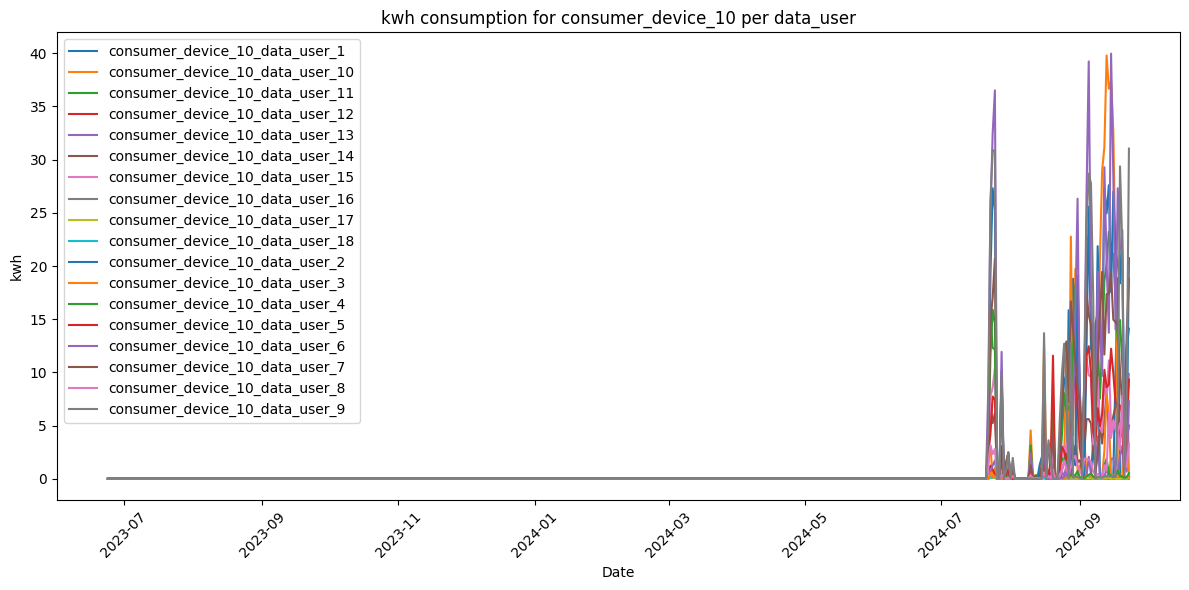

In [13]:
consumer_10_data = aggregated_data[aggregated_data['Source'].str.contains('consumer_device_10')]

plt.figure(figsize=(12,6))
for data_user in consumer_10_data['Source'].unique():
    user_data = consumer_10_data[consumer_10_data['Source'] == data_user]
    plt.plot(user_data['Date'], user_data['kwh'], label=data_user)

plt.xlabel('Date')
plt.ylabel('kwh')
plt.title('kwh consumption for consumer_device_10 per data_user')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

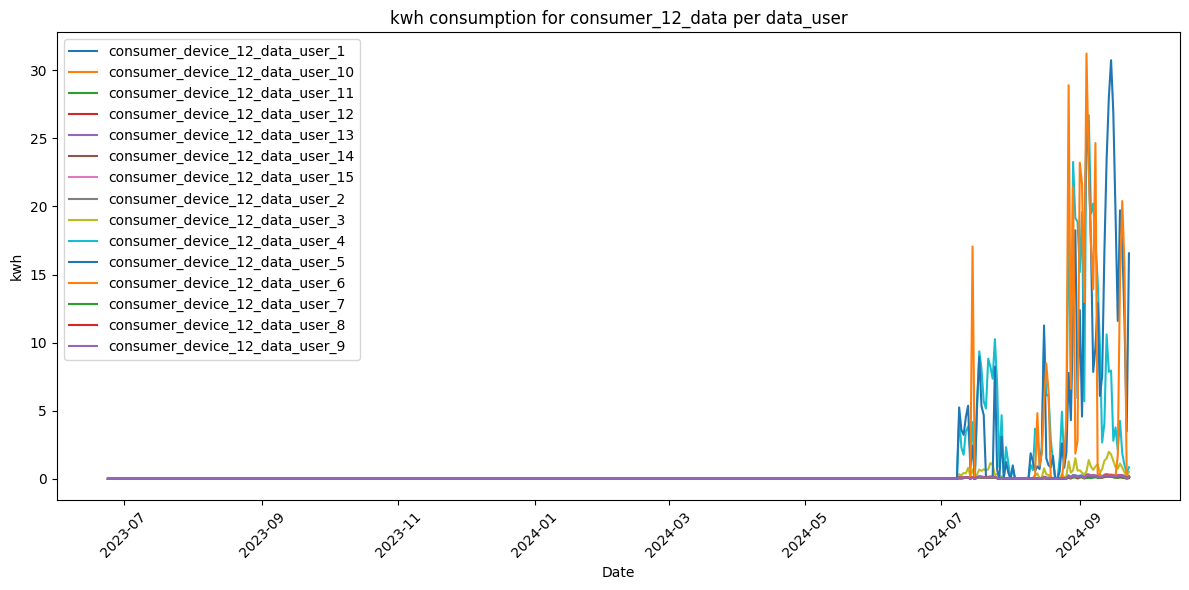

In [14]:
consumer_12_data = aggregated_data[aggregated_data['Source'].str.contains('consumer_device_12')]

plt.figure(figsize=(12,6))
for data_user in consumer_12_data['Source'].unique():
    user_data = consumer_12_data[consumer_12_data['Source'] == data_user]
    plt.plot(user_data['Date'], user_data['kwh'], label=data_user)

plt.xlabel('Date')
plt.ylabel('kwh')
plt.title('kwh consumption for consumer_12_data per data_user')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

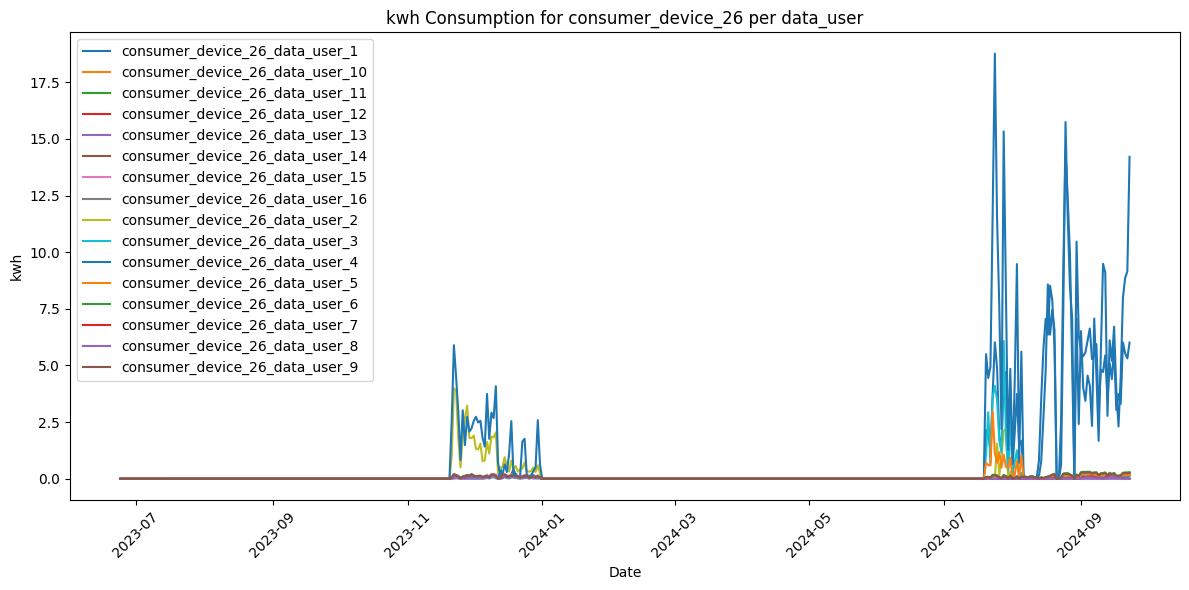

In [15]:
# Filter data for consumer_device_26
consumer_26_data = aggregated_data[aggregated_data['Source'].str.contains('consumer_device_26')]

# Create the plot
plt.figure(figsize=(12, 6))
for data_user in consumer_26_data['Source'].unique():
    user_data = consumer_26_data[consumer_26_data['Source'] == data_user]
    plt.plot(user_data['Date'], user_data['kwh'], label=data_user)

plt.xlabel('Date')
plt.ylabel('kwh')
plt.title('kwh Consumption for consumer_device_26 per data_user')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

### ini consumer 1 device 26 menyusahkan

(array([0]), [Text(0, 0, '')])

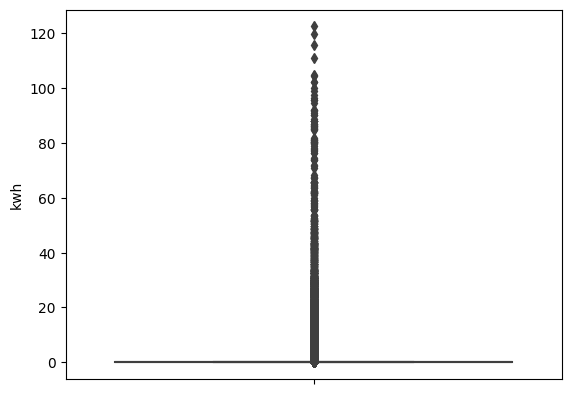

In [16]:
import seaborn as sns
sns.boxplot(y='kwh', data=aggregated_data)
plt.xticks(rotation=90)

In [17]:
min_date = aggregated_data['Date'].min()
max_date = aggregated_data['Date'].max()

print(f'Minimum date_time: {min_date}')
print(f'Maximum date_time: {max_date}')

Minimum date_time: 2023-06-24
Maximum date_time: 2024-09-23


In [18]:
aggregated_data.head()

,Source,Date,kwh
0,consumer_device_10_data_user_1,2023-06-24,0.0
1,consumer_device_10_data_user_1,2023-06-25,0.0
2,consumer_device_10_data_user_1,2023-06-26,0.0
3,consumer_device_10_data_user_1,2023-06-27,0.0
4,consumer_device_10_data_user_1,2023-06-28,0.0


In [19]:
aggregated_data[aggregated_data.columns[aggregated_data.isnull().any()]].isnull().sum()

Series([], dtype: float64)

In [20]:
aggregated_data.isnull().any()

Source    False
Date      False
kwh       False
dtype: bool

template for forecasting

In [69]:

date_rng = pd.date_range(start='2024-07-01', end=max_date, freq='D')

complete_data = pd.DataFrame()

for source in aggregated_data['Source'].unique():
    source_data = aggregated_data[aggregated_data['Source'] == source].copy()
    source_data['Date'] = pd.to_datetime(source_data['Date'])
    source_date_rng = pd.DataFrame({'Date': date_rng})
    source_date_rng['Source'] = source
    
    source_data = pd.merge(source_date_rng, source_data, on=['Date', 'Source'], how='left')
    complete_data = pd.concat([complete_data, source_data], ignore_index=True)

In [70]:
complete_data.tail()

,Date,Source,kwh
49720,2024-09-19,consumer_device_9_data_user_9,0.0
49721,2024-09-20,consumer_device_9_data_user_9,0.0
49722,2024-09-21,consumer_device_9_data_user_9,0.0
49723,2024-09-22,consumer_device_9_data_user_9,0.0
49724,2024-09-23,consumer_device_9_data_user_9,0.0


In [71]:
complete_data.isnull().any()

Date      False
Source    False
kwh       False
dtype: bool

In [72]:
climate_df = pd.read_excel('/kaggle/input/ibmskillsbuildhydropowerclimateoptimisationupdated/Climate Data/Climate Data/Kalam Climate Data.xlsx')
# Convert to datetime
complete_data["Date"] = pd.to_datetime(complete_data["Date"])
climate_df["Date Time"] = pd.to_datetime(climate_df["Date Time"])


In [73]:
print(climate_df["Date Time"].min())
print(climate_df["Date Time"].max())

2023-06-03 13:00:00
2024-10-25 00:00:00


In [74]:
climate_df = pd.read_excel('/kaggle/input/ibmskillsbuildhydropowerclimateoptimisationupdated/Climate Data/Climate Data/Kalam Climate Data.xlsx')
# Convert to datetime
complete_data["Date"] = pd.to_datetime(complete_data["Date"])
climate_df["Date Time"] = pd.to_datetime(climate_df["Date Time"])

# Aggregate climate data to daily level
climate_daily = climate_df.groupby(climate_df["Date Time"].dt.date).agg({
    "Temperature (°C)": "mean",
    "Dewpoint Temperature (°C)": "mean",
    "U Wind Component (m/s)": "mean",
    "V Wind Component (m/s)": "mean",
    "Total Precipitation (mm)": "sum",
    "Snowfall (mm)": "sum",
    "Snow Cover (%)": "mean",
}).reset_index()

# Convert 'Date' column in climate_daily to datetime format
climate_daily.rename(columns={"Date Time": "Date"}, inplace=True)
climate_daily["Date"] = pd.to_datetime(climate_daily["Date"])  # Ensure datetime64[ns]

# Merge with complete_data
complete_data = complete_data.merge(climate_daily, on="Date", how="left")

In [75]:
complete_data.tail()

,Date,Source,kwh,Temperature (°C),Dewpoint Temperature (°C),U Wind Component (m/s),V Wind Component (m/s),Total Precipitation (mm),Snowfall (mm),Snow Cover (%)
49720,2024-09-19,consumer_device_9_data_user_9,0.0,10.415409,1.626889,-0.011655,-0.156432,0.005865,0.000001,0.004395
49721,2024-09-20,consumer_device_9_data_user_9,0.0,12.154204,1.086294,-0.133177,-0.239482,0.002294,0.000000,0.000651
49722,2024-09-21,consumer_device_9_data_user_9,0.0,13.219773,1.432244,-0.098764,-0.306270,0.000825,0.000000,0.000000
49723,2024-09-22,consumer_device_9_data_user_9,0.0,14.080013,1.195233,-0.069137,-0.309662,0.000047,0.000000,0.000000
49724,2024-09-23,consumer_device_9_data_user_9,0.0,13.384137,3.404842,0.050238,-0.223926,0.000249,0.000000,0.000000


In [109]:
#feature engineering
complete_data[['consumer_device', 'data_user']] = complete_data['Source'].str.extract(r'(consumer_device_\d+)_data_user_(\d+)')


In [110]:
complete_data.head()

,Date,Source,kwh,Temperature (°C),Dewpoint Temperature (°C),U Wind Component (m/s),V Wind Component (m/s),Total Precipitation (mm),Snowfall (mm),Snow Cover (%),consumer_device,data_user,day_of_week,is_weekend,day_of_year,Week,Month,temp_dew_diff,wind_speed,precip_snow_ratio
0,2024-07-01,consumer_device_10_data_user_1,0.0,14.942716,8.577978,0.320656,0.228913,0.006270,0.0,0.021322,consumer_device_10,1,0,0,183,27,7,6.364738,0.393982,6269.603
1,2024-07-02,consumer_device_10_data_user_1,0.0,15.080516,7.864159,0.324458,0.259530,0.002404,0.0,0.006266,consumer_device_10,1,1,0,184,27,7,7.216357,0.415487,2404.193
2,2024-07-03,consumer_device_10_data_user_1,0.0,15.770147,9.578964,0.275826,0.350732,0.004334,0.0,0.002116,consumer_device_10,1,2,0,185,27,7,6.191182,0.446198,4333.780
3,2024-07-04,consumer_device_10_data_user_1,0.0,15.277408,11.471116,0.441994,0.350547,0.044775,0.0,0.000000,consumer_device_10,1,3,0,186,27,7,3.806292,0.564130,44775.052
4,2024-07-05,consumer_device_10_data_user_1,0.0,13.950413,8.368979,0.368354,0.321995,0.024740,0.0,0.000000,consumer_device_10,1,4,0,187,27,7,5.581434,0.489249,24740.076


# maybe using holiday or like calendar feature

In [113]:
all_feature = climate_daily.copy()

all_feature['Date'] = pd.to_datetime(all_feature['Date'])

all_feature['day_of_week'] = all_feature['Date'].dt.dayofweek
all_feature['is_weekend'] = all_feature['day_of_week'].isin([5, 6]).astype(int)
all_feature['day_of_year'] = all_feature['Date'].dt.dayofyear
all_feature['Week'] = all_feature['Date'].dt.isocalendar().week
all_feature['Month'] = all_feature['Date'].dt.month
all_feature["temp_dew_diff"] = all_feature["Temperature (°C)"] - all_feature["Dewpoint Temperature (°C)"]
all_feature["wind_speed"] = (all_feature["U Wind Component (m/s)"]**2 + all_feature["V Wind Component (m/s)"]**2)**0.5
all_feature["precip_snow_ratio"] = all_feature["Total Precipitation (mm)"] / (all_feature["Snowfall (mm)"] + 1e-6)
all_feature = all_feature.sort_values(by=['Date'])
all_feature.head()


,Date,Temperature (°C),Dewpoint Temperature (°C),U Wind Component (m/s),V Wind Component (m/s),Total Precipitation (mm),Snowfall (mm),Snow Cover (%),day_of_week,is_weekend,day_of_year,Week,Month,temp_dew_diff,wind_speed,precip_snow_ratio
0,2023-06-03,1.860280,-3.348664,0.025054,-0.657726,0.004557,0.000000e+00,99.972656,5,1,154,22,6,5.208944,0.658203,4557.000000
1,2023-06-04,3.992740,-1.905203,-0.180909,-0.505298,0.024096,0.000000e+00,99.972656,6,1,155,22,6,5.897942,0.536706,24096.402000
2,2023-06-05,4.794523,-3.781657,-0.145114,-0.498183,0.011580,1.166000e-06,99.972656,0,0,156,23,6,8.576181,0.518888,5346.083380
3,2023-06-06,6.304390,-4.670615,0.018054,-0.478623,0.008914,5.220000e-08,99.972656,1,0,157,23,6,10.975005,0.478963,8471.506368
4,2023-06-07,7.003922,-3.965763,0.083701,-0.516598,0.008649,0.000000e+00,99.972656,2,0,158,23,6,10.969686,0.523335,8649.500000


In [114]:

complete_data['Date'] = pd.to_datetime(complete_data['Date'])

complete_data['day_of_week'] = complete_data['Date'].dt.dayofweek
complete_data['is_weekend'] = complete_data['day_of_week'].isin([5, 6]).astype(int)
complete_data['day_of_year'] = complete_data['Date'].dt.dayofyear
complete_data['Week'] = complete_data['Date'].dt.isocalendar().week
complete_data['Month'] = complete_data['Date'].dt.month
complete_data["temp_dew_diff"] = complete_data["Temperature (°C)"] - complete_data["Dewpoint Temperature (°C)"]
complete_data["wind_speed"] = (complete_data["U Wind Component (m/s)"]**2 + complete_data["V Wind Component (m/s)"]**2)**0.5
complete_data["precip_snow_ratio"] = complete_data["Total Precipitation (mm)"] / (complete_data["Snowfall (mm)"] + 1e-6)

In [80]:
complete_data.head()

,Date,Source,kwh,Temperature (°C),Dewpoint Temperature (°C),U Wind Component (m/s),V Wind Component (m/s),Total Precipitation (mm),Snowfall (mm),Snow Cover (%),consumer_device,data_user,day_of_week,is_weekend,day_of_year,Week,Month,temp_dew_diff,wind_speed,precip_snow_ratio
0,2024-07-01,consumer_device_10_data_user_1,0.0,14.942716,8.577978,0.320656,0.228913,0.006270,0.0,0.021322,consumer_device_10,data_user_1,0,0,183,27,7,6.364738,0.393982,6269.603
1,2024-07-02,consumer_device_10_data_user_1,0.0,15.080516,7.864159,0.324458,0.259530,0.002404,0.0,0.006266,consumer_device_10,data_user_1,1,0,184,27,7,7.216357,0.415487,2404.193
2,2024-07-03,consumer_device_10_data_user_1,0.0,15.770147,9.578964,0.275826,0.350732,0.004334,0.0,0.002116,consumer_device_10,data_user_1,2,0,185,27,7,6.191182,0.446198,4333.780
3,2024-07-04,consumer_device_10_data_user_1,0.0,15.277408,11.471116,0.441994,0.350547,0.044775,0.0,0.000000,consumer_device_10,data_user_1,3,0,186,27,7,3.806292,0.564130,44775.052
4,2024-07-05,consumer_device_10_data_user_1,0.0,13.950413,8.368979,0.368354,0.321995,0.024740,0.0,0.000000,consumer_device_10,data_user_1,4,0,187,27,7,5.581434,0.489249,24740.076


In [116]:
complete_data = complete_data.sort_values(by=['Source', 'Date']).reset_index(drop=True)

In [117]:
complete_data['Source'] = complete_data['Source'].astype('category')
print('Unique devices/users:', complete_data['Source'].nunique())

Unique devices/users: 585


In [118]:
for col in complete_data.select_dtypes(include='object').columns:
    complete_data[col] = complete_data[col].astype('category')

In [120]:
#X = complete_data.drop(columns=['Date', 'kwh', 'Month', 'Snow Cover (%)','Snowfall (mm)', 'is_weekend','consumer_device','data_user'])
X = complete_data.drop(columns=['kwh', 'Date', 'Source']) #more make sense
y = complete_data.kwh

In [85]:
X

,Temperature (°C),Dewpoint Temperature (°C),U Wind Component (m/s),V Wind Component (m/s),Total Precipitation (mm),Snowfall (mm),Snow Cover (%),consumer_device,data_user,day_of_week,is_weekend,day_of_year,Week,Month,temp_dew_diff,wind_speed,precip_snow_ratio
0,14.942716,8.577978,0.320656,0.228913,0.006270,0.000000,0.021322,consumer_device_10,data_user_1,0,0,183,27,7,6.364738,0.393982,6269.603000
1,15.080516,7.864159,0.324458,0.259530,0.002404,0.000000,0.006266,consumer_device_10,data_user_1,1,0,184,27,7,7.216357,0.415487,2404.193000
2,15.770147,9.578964,0.275826,0.350732,0.004334,0.000000,0.002116,consumer_device_10,data_user_1,2,0,185,27,7,6.191182,0.446198,4333.780000
3,15.277408,11.471116,0.441994,0.350547,0.044775,0.000000,0.000000,consumer_device_10,data_user_1,3,0,186,27,7,3.806292,0.564130,44775.052000
4,13.950413,8.368979,0.368354,0.321995,0.024740,0.000000,0.000000,consumer_device_10,data_user_1,4,0,187,27,7,5.581434,0.489249,24740.076000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49720,10.415409,1.626889,-0.011655,-0.156432,0.005865,0.000001,0.004395,consumer_device_9,data_user_9,3,0,263,38,9,8.788520,0.156865,2917.870647
49721,12.154204,1.086294,-0.133177,-0.239482,0.002294,0.000000,0.000651,consumer_device_9,data_user_9,4,0,264,38,9,11.067910,0.274021,2293.720000
49722,13.219773,1.432244,-0.098764,-0.306270,0.000825,0.000000,0.000000,consumer_device_9,data_user_9,5,1,265,38,9,11.787528,0.321800,824.710000
49723,14.080013,1.195233,-0.069137,-0.309662,0.000047,0.000000,0.000000,consumer_device_9,data_user_9,6,1,266,38,9,12.884780,0.317286,46.610000


In [39]:
y

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
49720    0.0
49721    0.0
49722    0.0
49723    0.0
49724    0.0
Name: kwh, Length: 49725, dtype: float32

In [121]:

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, shuffle=True,test_size=0.2)

In [122]:
from lightgbm import LGBMRegressor
model = LGBMRegressor(
    n_estimators=1000,
    objective='rmse',
    random_state=42,
    early_stopping_rounds=100,
    verbose=1
)
model.fit(X_train, y_train,
         eval_set=[(X_test, y_test)],
         )

[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002414 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 888
[LightGBM] [Info] Number of data points in the train set: 39780, number of used features: 17
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 1.217320
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 1.96399


LGBMRegressor(early_stopping_rounds=100, n_estimators=1000, objective='rmse',
              random_state=42, verbose=1)

In [123]:
y_pred = model.predict(X_test)

In [124]:
np.sqrt(mean_squared_error(y_pred, y_test))

1.9639923752979545

In [125]:
X_train.head()

,Temperature (°C),Dewpoint Temperature (°C),U Wind Component (m/s),V Wind Component (m/s),Total Precipitation (mm),Snowfall (mm),Snow Cover (%),consumer_device,data_user,day_of_week,is_weekend,day_of_year,Week,Month,temp_dew_diff,wind_speed,precip_snow_ratio
30892,14.416216,10.817158,0.094943,0.337096,0.027924,0.0,0.0,consumer_device_32,15,2,0,220,32,8,3.599058,0.350211,27924.260
35914,16.525053,11.732950,0.184556,0.371486,0.021259,0.0,0.0,consumer_device_36,1,2,0,227,33,8,4.792103,0.414804,21259.418
5757,11.767033,9.057457,0.045252,-0.016033,0.115252,0.0,0.0,consumer_device_13,8,6,1,245,35,9,2.709576,0.048008,115252.247
48338,10.570746,7.315720,-0.113471,0.072697,0.011328,0.0,0.0,consumer_device_8,2,2,0,241,35,8,3.255026,0.134761,11327.726
32520,11.641286,8.495211,-0.042563,0.241955,0.054808,0.0,0.0,consumer_device_33,2,1,0,233,34,8,3.146075,0.245670,54807.715


In [126]:
complete_data.head()

,Date,Source,kwh,Temperature (°C),Dewpoint Temperature (°C),U Wind Component (m/s),V Wind Component (m/s),Total Precipitation (mm),Snowfall (mm),Snow Cover (%),consumer_device,data_user,day_of_week,is_weekend,day_of_year,Week,Month,temp_dew_diff,wind_speed,precip_snow_ratio
0,2024-07-01,consumer_device_10_data_user_1,0.0,14.942716,8.577978,0.320656,0.228913,0.006270,0.0,0.021322,consumer_device_10,1,0,0,183,27,7,6.364738,0.393982,6269.603
1,2024-07-02,consumer_device_10_data_user_1,0.0,15.080516,7.864159,0.324458,0.259530,0.002404,0.0,0.006266,consumer_device_10,1,1,0,184,27,7,7.216357,0.415487,2404.193
2,2024-07-03,consumer_device_10_data_user_1,0.0,15.770147,9.578964,0.275826,0.350732,0.004334,0.0,0.002116,consumer_device_10,1,2,0,185,27,7,6.191182,0.446198,4333.780
3,2024-07-04,consumer_device_10_data_user_1,0.0,15.277408,11.471116,0.441994,0.350547,0.044775,0.0,0.000000,consumer_device_10,1,3,0,186,27,7,3.806292,0.564130,44775.052
4,2024-07-05,consumer_device_10_data_user_1,0.0,13.950413,8.368979,0.368354,0.321995,0.024740,0.0,0.000000,consumer_device_10,1,4,0,187,27,7,5.581434,0.489249,24740.076


# Forecast

In [46]:
ss.head()

,ID,kwh
0,2024-09-24_consumer_device_12_data_user_1,0
1,2024-09-25_consumer_device_12_data_user_1,0
2,2024-09-26_consumer_device_12_data_user_1,0
3,2024-09-27_consumer_device_12_data_user_1,0
4,2024-09-28_consumer_device_12_data_user_1,0


In [127]:
import pandas as pd

def forecast(featr, ss, model, X_train):
    # Create copies to avoid modifying originals
    template = ss.copy()
    feature = featr.copy()
    
    # First extract date and other info from ID
    # Extract date
    template['Date'] = template['ID'].str.extract(r'(\d{4}-\d{2}-\d{2})')
    
    # Extract consumer device
    template['consumer_device'] = template['ID'].str.extract(r'_(consumer_device_\d+)')
    
    # Extract data user 
    template['data_user'] = template['ID'].str.extract(r'_data_user_(\d+)')
    
    # Convert both Date columns to same format for merging
    template['Date'] = pd.to_datetime(template['Date'])
    feature['Date'] = pd.to_datetime(feature['Date'])
    
    # Now merge template with feature data based on Date
    merged_df = pd.merge(template, feature, on='Date', how='left')
    
    # Handle categorical columns
    for col in ['consumer_device', 'data_user']:
        if col in merged_df.columns:
            merged_df[col] = pd.Categorical(
                merged_df[col],
                categories=X_train[col].cat.categories
            )
    
    # Drop columns not needed for prediction
    columns_to_drop = ['ID', 'kwh']
    X = merged_df.drop(columns=[col for col in columns_to_drop if col in merged_df.columns])
    
    # Ensure X has the same columns as X_train
    X = X[X_train.columns]
    
    # Predict
    preds = model.predict(X)
    preds = np.maximum(preds, 0)
    
    # Prepare the result dataframe
    result = template[['ID']].copy()
    result['kwh'] = preds
    
    return result, X
pred, cekdlu = forecast(all_feature, ss, model, X_train)
pred

,ID,kwh
0,2024-09-24_consumer_device_12_data_user_1,0.577159
1,2024-09-25_consumer_device_12_data_user_1,1.688765
2,2024-09-26_consumer_device_12_data_user_1,0.000000
3,2024-09-27_consumer_device_12_data_user_1,0.000000
4,2024-09-28_consumer_device_12_data_user_1,0.000000
...,...,...
6009,2024-10-20_consumer_device_8_data_user_9,1.019365
6010,2024-10-21_consumer_device_8_data_user_9,1.456313
6011,2024-10-22_consumer_device_8_data_user_9,1.165462
6012,2024-10-23_consumer_device_8_data_user_9,0.626967


In [108]:
cekdlu.data_user.dtype

CategoricalDtype(categories=['1', '10', '11', '12', '13', '14', '15', '16', '17', '18',
                  '19', '2', '20', '21', '3', '4', '5', '6', '7', '8', '9'],
, ordered=False, categories_dtype=object)

In [62]:
pred.to_csv('common_sense_2.csv', index=False)

## Rolling Lag 

In [132]:
import pandas as pd
import numpy as np

def create_features(df):
    df = df.copy()
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Basic time features
    df['day_of_week'] = df['Date'].dt.dayofweek
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    df['day_of_year'] = df['Date'].dt.dayofyear
    df['Week'] = df['Date'].dt.isocalendar().week
    df['Month'] = df['Date'].dt.month
    
    # Weather derived features
    df["temp_dew_diff"] = df["Temperature (°C)"] - df["Dewpoint Temperature (°C)"]
    df["wind_speed"] = (df["U Wind Component (m/s)"]**2 + df["V Wind Component (m/s)"]**2)**0.5
    df["precip_snow_ratio"] = df["Total Precipitation (mm)"] / (df["Snowfall (mm)"] + 1e-6)
    
    return df

def add_lag_features(df, target_col='kwh', id_cols=['consumer_device', 'data_user']):
    """Add lag features for each unique consumer/user combination"""
    df = df.copy()
    df = df.sort_values(by=['Date'] + id_cols)
    
    # Create lag features for each unique ID combination
    for lag in [1, 2, 3, 7]:  # 1-day, 2-day, 3-day and 1-week lag
        df[f'{target_col}_lag_{lag}'] = df.groupby(id_cols)[target_col].shift(lag)
    
    # Create rolling window features - fixed to avoid index issues
    for window in [3, 7, 14]:
        # Process each group separately and concatenate results
        grouped = df.groupby(id_cols)
        
        # Rolling mean
        rolling_mean = grouped[target_col].apply(lambda x: x.rolling(window=window).mean().shift(1))
        df[f'{target_col}_rolling_mean_{window}'] = rolling_mean.values
        
        # Rolling std
        rolling_std = grouped[target_col].apply(lambda x: x.rolling(window=window).std().shift(1))
        df[f'{target_col}_rolling_std_{window}'] = rolling_std.values
        
        # Rolling min
        rolling_min = grouped[target_col].apply(lambda x: x.rolling(window=window).min().shift(1))
        df[f'{target_col}_rolling_min_{window}'] = rolling_min.values
        
        # Rolling max
        rolling_max = grouped[target_col].apply(lambda x: x.rolling(window=window).max().shift(1))
        df[f'{target_col}_rolling_max_{window}'] = rolling_max.values
    
    return df

# Apply to both dataframes
all_feature = create_features(climate_daily.copy())
all_feature = all_feature.sort_values(by=['Date'])


In [133]:
complete_data = create_features(complete_data.copy())
if 'kwh' in complete_data.columns:
    complete_data = add_lag_features(complete_data)

In [135]:
X = complete_data.drop(columns=['kwh', 'Date', 'Source']) #more make sense
y = complete_data.kwh
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, shuffle=True,test_size=0.2)

In [136]:
from lightgbm import LGBMRegressor
model = LGBMRegressor(
    n_estimators=1000,
    objective='rmse',
    random_state=42,
    early_stopping_rounds=100,
    verbose=1
)
model.fit(X_train, y_train,
         eval_set=[(X_test, y_test)],
         )

[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006865 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4968
[LightGBM] [Info] Number of data points in the train set: 39780, number of used features: 33
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 1.215004
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[969]	valid_0's rmse: 1.48989


LGBMRegressor(early_stopping_rounds=100, n_estimators=1000, objective='rmse',
              random_state=42, verbose=1)

In [137]:
import pandas as pd
import numpy as np

def forecast_recursive(featr, ss, model, X_train, historical_data=None):
    """
    Forecast with recursive approach for 30 days
    
    Parameters:
    - featr: Feature dataframe with weather data
    - ss: Submission template
    - model: Trained model
    - X_train: Training data with correct column structure
    - historical_data: Historical data with kwh values for calculating lag features
    """
    # Create copies to avoid modifying originals
    template = ss.copy()
    feature = featr.copy()
    
    # Extract date and ID components
    template['Date'] = template['ID'].str.extract(r'(\d{4}-\d{2}-\d{2})')
    template['consumer_device'] = template['ID'].str.extract(r'_(consumer_device_\d+)')
    template['data_user'] = template['ID'].str.extract(r'_data_user_(\d+)')
    
    # Convert dates for merging
    template['Date'] = pd.to_datetime(template['Date'])
    feature['Date'] = pd.to_datetime(feature['Date'])
    
    # Sort by date for proper forecasting
    template = template.sort_values(by=['Date', 'consumer_device', 'data_user'])
    
    # Combine historical and template data for lag calculations
    if historical_data is not None:
        historical_data = historical_data.copy()
        historical_data['Date'] = pd.to_datetime(historical_data['Date'])
        
        # Ensure historical_data has the same ID components extracted
        if 'consumer_device' not in historical_data.columns:
            historical_data['consumer_device'] = historical_data['ID'].str.extract(r'_(consumer_device_\d+)')
        if 'data_user' not in historical_data.columns:
            historical_data['data_user'] = historical_data['ID'].str.extract(r'_data_user_(\d+)')
        
        # Create a combined dataframe for recursive forecasting
        combined_data = pd.concat([historical_data, template], sort=False)
        combined_data = combined_data.sort_values(by=['Date', 'consumer_device', 'data_user'])
    else:
        combined_data = template.copy()
    
    # Merge with weather features
    combined_data = pd.merge(combined_data, feature, on='Date', how='left')
    
    # Initialize kwh column in combined_data if it doesn't exist
    if 'kwh' not in combined_data.columns:
        combined_data['kwh'] = np.nan
    
    # Get unique dates in template for forecasting loop
    forecast_dates = template['Date'].unique()
    
    # Handle categorical columns
    for col in ['consumer_device', 'data_user']:
        if col in combined_data.columns:
            combined_data[col] = pd.Categorical(
                combined_data[col], 
                categories=X_train[col].cat.categories
            )
    
    # Recursive forecasting loop
    for date in forecast_dates:
        # Get current date mask
        current_mask = combined_data['Date'] == date
        
        # Add lag and rolling features up to this date
        temp_df = add_lag_features(combined_data[combined_data['Date'] <= date])
        
        # Get current date rows with features
        current_data = temp_df[current_mask].copy()
        
        # Prepare prediction features
        X_current = current_data.drop(columns=['ID', 'kwh', 'Date'])
        
        # Ensure X has the same columns as X_train
        missing_cols = set(X_train.columns) - set(X_current.columns)
        for col in missing_cols:
            X_current[col] = 0  # Fill missing columns with default values
        
        X_current = X_current[X_train.columns]
        
        # Predict
        preds = model.predict(X_current)
        preds = np.maximum(preds, 0)  # Ensure non-negative predictions
        
        # Update the combined_data with predictions
        combined_data.loc[current_mask, 'kwh'] = preds
    
    # Extract final predictions
    result = template[['ID']].copy()
    result = pd.merge(result, combined_data[['ID', 'kwh']], on='ID', how='left')
    
    return result

# Call the function
pred = forecast_recursive(all_feature, ss, model, X_train, historical_data=complete_data)

In [138]:
pred.to_csv('common_sense_lag.csv', index=False)